In [ ]:
%matplotlib inline

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from os.path import normpath, basename
from skimage import io, transform
from PIL import Image

plt.ion()   # interactive mode

In [2]:
class TextureDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        path = os.path.dirname(os.path.dirname(self.root_dir))
        self.classes = os.listdir(path)

    def __len__(self):
        lista = os.listdir(self.root_dir)
        return len(lista)

    def __getitem__(self, idx):
        lista = os.listdir(self.root_dir)
        img_name = os.path.join(self.root_dir, lista[idx])
        image = io.imread(img_name)
        img = Image.fromarray(image)
        path = os.path.dirname(self.root_dir)
        label = basename(normpath(path))
        label = self.classes.index(label)

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
    def classes(self):

        return self.classes

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

root = r'D:\Google Drive\UNICAMP\IC\KTH-TIPS\KTH-TIPS2-a'
classes = os.listdir(root)
data_dir = []
image_datasets = {'train': [] , 'val': []}

for i in range(len(classes)):
    data_dir.append(os.path.join(root,classes[i]))
    
subclasses = os.listdir(data_dir[0]) # Para que funcione, todas as classes devem ter o mesmo numero de subclasses

val_samp = 'sample_b'
train_samp = subclasses[:]
train_samp.remove(val_samp)
    
for i in range(len(classes)):
    image_datasets['val'].append(TextureDataset(os.path.join(data_dir[i], val_samp), data_transforms['val']))
    for j in range(len(train_samp)):
        image_datasets['train'].append(TextureDataset(os.path.join(data_dir[i], train_samp[j]), data_transforms['train']))

image_datasets = {x: torch.utils.data.ConcatDataset(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets['train'].__getitem__(200))
print(image_datasets['val'].__getitem__(1100))
print(image_datasets['train'].__len__())
print(image_datasets['val'].__len__())

(tensor([[[-1.7412, -1.7069, -1.6898,  ..., -1.0390, -1.3130, -1.4843],
         [-1.6727, -1.6555, -1.6555,  ..., -0.7308, -1.0219, -1.2617],
         [-1.5699, -1.5870, -1.6213,  ..., -0.2684, -0.5938, -0.9534],
         ...,
         [-0.5253, -0.5596, -0.5424,  ..., -0.7822, -0.8164, -0.7993],
         [-0.6623, -0.6965, -0.7137,  ..., -0.7650, -0.7822, -0.7650],
         [-0.7479, -0.7993, -0.8507,  ..., -0.7479, -0.7650, -0.7479]],

        [[-1.6155, -1.5805, -1.5630,  ..., -0.9153, -1.1954, -1.3880],
         [-1.5455, -1.5280, -1.5455,  ..., -0.6001, -0.9153, -1.1779],
         [-1.4580, -1.4755, -1.5105,  ..., -0.1450, -0.4951, -0.8803],
         ...,
         [-0.4951, -0.5126, -0.4776,  ..., -0.6702, -0.6702, -0.6176],
         [-0.5651, -0.6001, -0.6352,  ..., -0.6352, -0.6352, -0.6001],
         [-0.6176, -0.6877, -0.7577,  ..., -0.6001, -0.6176, -0.6001]],

        [[-1.4036, -1.3687, -1.3513,  ..., -0.6193, -0.9156, -1.1247],
         [-1.3164, -1.2816, -1.2816,  ..., -

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor([[[[ 0.9817,  0.9817,  0.9474,  ...,  0.1083,  0.0398, -0.0116],
          [ 0.2967,  0.3138,  0.3309,  ...,  0.0398, -0.0801, -0.1828],
          [ 0.1597,  0.2282,  0.3138,  ..., -0.0972, -0.2171, -0.3027],
          ...,
          [ 0.4337,  0.5193,  0.6392,  ...,  0.0569,  0.1768,  0.2624],
          [ 0.6049,  0.7077,  0.8276,  ...,  0.1426,  0.2796,  0.3823],
          [ 0.6734,  0.7419,  0.8447,  ...,  0.2453,  0.3823,  0.4851]],

         [[ 1.1506,  1.1856,  1.2031,  ...,  0.3452,  0.2752,  0.2227],
          [ 0.5378,  0.5378,  0.5203,  ...,  0.2752,  0.1352,  0.0301],
          [ 0.4153,  0.4503,  0.4678,  ...,  0.1352,  0.0126, -0.0749],
          ...,
          [ 0.6078,  0.7304,  0.9230,  ...,  0.2227,  0.3452,  0.4328],
          [ 0.7479,  0.9055,  1.1155,  ...,  0.2927,  0.4503,  0.5553],
          [ 0.8179,  0.9405,  1.0980,  ...,  0.4153,  0.5553,  0.6604]],

         [[ 0.8274,  0.8099,  0.7576,  ..., -0.0267, -0.0964, -0.1487],
          [-0.0092, -0.0092, -

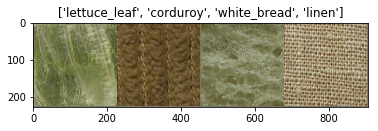

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#print (next((iter(dataloaders['train']))))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#inputs, classes = image_datasets['train'].__getitem__(200)

print (inputs)
print (classes)
print (class_names)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#imshow(out)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8682 Acc: 0.7251
val Loss: 1.2990 Acc: 0.7458

Epoch 1/24
----------
train Loss: 0.4910 Acc: 0.8450
val Loss: 2.0902 Acc: 0.7576

Epoch 2/24
----------
train Loss: 0.3744 Acc: 0.8810
val Loss: 1.7568 Acc: 0.7458

Epoch 3/24
----------
train Loss: 0.3103 Acc: 0.9009
val Loss: 3.1466 Acc: 0.7214

Epoch 4/24
----------
train Loss: 0.2854 Acc: 0.9152
val Loss: 2.5643 Acc: 0.7146

Epoch 5/24
----------
train Loss: 0.2033 Acc: 0.9357
val Loss: 3.4201 Acc: 0.7172

Epoch 6/24
----------
train Loss: 0.1443 Acc: 0.9561
val Loss: 2.1975 Acc: 0.7988

Epoch 7/24
----------
train Loss: 0.1080 Acc: 0.9708
val Loss: 2.4262 Acc: 0.7862

Epoch 8/24
----------
train Loss: 0.0947 Acc: 0.9734
val Loss: 2.3105 Acc: 0.7677

Epoch 9/24
----------
train Loss: 0.0999 Acc: 0.9737
val Loss: 2.8415 Acc: 0.7820

Epoch 10/24
----------
train Loss: 0.0732 Acc: 0.9789
val Loss: 2.4034 Acc: 0.7803

Epoch 11/24
----------
train Loss: 0.0845 Acc: 0.9775
val Loss: 2.6179 Acc: 0.7753

Ep

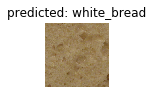

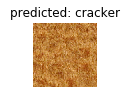

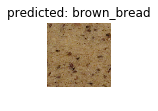

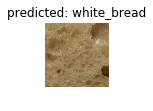

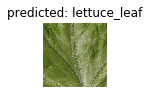

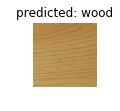

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0215 Acc: 0.6658
val Loss: 0.9164 Acc: 0.7668

Epoch 1/24
----------
train Loss: 0.6636 Acc: 0.7857
val Loss: 0.9810 Acc: 0.7433

Epoch 2/24
----------
train Loss: 0.6396 Acc: 0.7915
val Loss: 0.9705 Acc: 0.7180

Epoch 3/24
----------
train Loss: 0.5721 Acc: 0.8117
val Loss: 1.0056 Acc: 0.7290

Epoch 4/24
----------
train Loss: 0.5893 Acc: 0.8161
val Loss: 1.1193 Acc: 0.7382

Epoch 5/24
----------
train Loss: 0.5328 Acc: 0.8322
val Loss: 1.1901 Acc: 0.7121

Epoch 6/24
----------
train Loss: 0.5252 Acc: 0.8295
val Loss: 1.0637 Acc: 0.6978

Epoch 7/24
----------
train Loss: 0.4856 Acc: 0.8456
val Loss: 0.9696 Acc: 0.7391

Epoch 8/24
----------
train Loss: 0.4512 Acc: 0.8591
val Loss: 1.0602 Acc: 0.7071

Epoch 9/24
----------
train Loss: 0.4480 Acc: 0.8547
val Loss: 1.0432 Acc: 0.7146

Epoch 10/24
----------
train Loss: 0.4535 Acc: 0.8588
val Loss: 1.0740 Acc: 0.7382

Epoch 11/24
----------
train Loss: 0.4557 Acc: 0.8567
val Loss: 1.1483 Acc: 0.7037

Ep

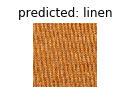

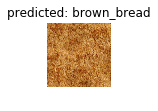

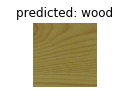

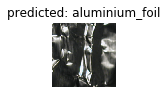

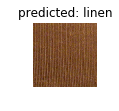

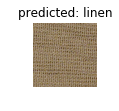

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()